In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute, roll_time_series
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 1: Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
df = pd.read_csv(url)
print("Dataset Loaded. Shape:", df.shape)

Dataset Loaded. Shape: (19735, 29)


In [3]:
df.head(5)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [4]:
# Convert "date" to datetime and set as index for time-based feature engineering
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [5]:
df.head(5)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [6]:
# Step 2: Prepare Data for Rolling Feature Extraction
# Add 'id' and 'time' columns for roll_time_series
df['id'] = 1  # Single ID to treat the entire dataset as one series
df['time'] = np.arange(len(df))  # Time index within the dataset

In [7]:
df_feats = df.drop(columns=['Appliances'])

In [8]:
# Step 3: Create Rolling Windows with `roll_time_series`
window_size = 10  # Define the desired window size
rolled_df = roll_time_series(df_feats, column_id="id", column_sort="time", max_timeshift=window_size - 1)

Rolling: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.76it/s]


In [9]:
# Step 4: Define fc_parameters with Top 7 Most Popular Features
fc_parameters = {
    "mean": None,
    "standard_deviation": None,
    # "skewness": None,
    # "kurtosis": None,
    # "minimum": None,
    # "maximum": None,
}

In [10]:
# Extract rolling features with the specified parameters
rolled_features = extract_features(
    rolled_df,
    column_id="id",
    column_sort="time",
    default_fc_parameters=fc_parameters,
    disable_progressbar=False
)

Feature Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.08it/s]


In [11]:
rolled_features.fillna(method='bfill', inplace=True)

In [12]:
rolled_features.index = pd.to_datetime(df.index)

In [13]:
rolled_features.head(3)

,lights__mean,lights__standard_deviation,T1__mean,T1__standard_deviation,RH_1__mean,RH_1__standard_deviation,T2__mean,T2__standard_deviation,RH_2__mean,RH_2__standard_deviation,...,Windspeed__mean,Windspeed__standard_deviation,Visibility__mean,Visibility__standard_deviation,Tdewpoint__mean,Tdewpoint__standard_deviation,rv1__mean,rv1__standard_deviation,rv2__mean,rv2__standard_deviation
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30.0,0.0,19.89,0.0,47.596667,0.000000,19.2,0.0,44.790000,0.000000,...,7.000000,0.000000,63.000000,0.000000,5.30,0.00000,13.275433,0.000000,13.275433,0.000000
2016-01-11 17:10:00,30.0,0.0,19.89,0.0,47.145000,0.451667,19.2,0.0,44.756250,0.033750,...,6.833333,0.166667,61.083333,1.916667,5.25,0.05000,15.940814,2.665381,15.940814,2.665381
2016-01-11 17:20:00,30.0,0.0,19.89,0.0,46.863333,0.542839,19.2,0.0,44.713056,0.067014,...,6.666667,0.272166,59.166667,3.129904,5.20,0.08165,20.174765,6.370939,20.174765,6.370939


In [14]:
# Check the shape of extracted rolling features
print("Rolled features shape:", rolled_features.shape)

Rolled features shape: (19735, 54)


In [15]:
# Step 5: Align the Target Variable and Original Features
# Keep only the rows aligned with the rolling windows for a consistent shape
original_features = df.copy() # .iloc[window_size - 1:].reset_index(drop=True)
y = original_features['Appliances']
original_features = original_features.drop(columns=['Appliances', 'id', 'time'])  # Remove target and auxiliary columns

In [16]:
original_features.shape

(19735, 27)

In [17]:
original_features.head(3)

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [18]:
# Step 6: Concatenate Original and Rolled Features
X_combined = pd.concat([original_features, rolled_features], axis=1)
X_combined.dropna(inplace=True)
print("Combined features shape:", X_combined.shape)

Combined features shape: (19735, 81)


In [19]:
# Calculate the variance of each feature before variance thresholding
feature_variances = X_combined.var()

(0.0, 20.0)

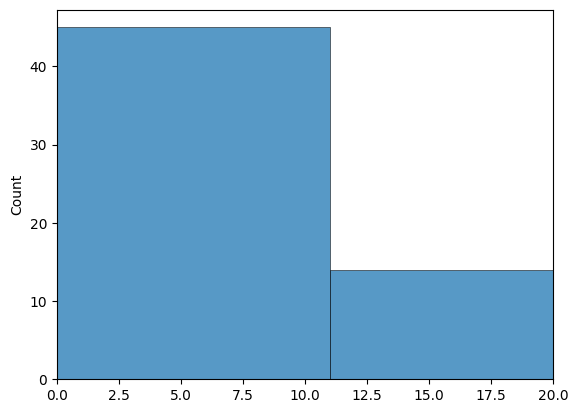

In [20]:
sns.histplot(feature_variances)
plt.xlim(0, 20)

In [58]:
# Step 7: Apply Variance Thresholding to Remove Low-Variance Features
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X_combined)
selected_feature_names = X_combined.columns[selector.get_support()]
X_var_df = X_combined # pd.DataFrame(X_var, columns=selected_feature_names)

In [59]:
X_var_df.shape

(19735, 81)

In [65]:
corr_matrix = X_var_df.corr().abs()
distance_matrix = 1 - corr_matrix
linked = linkage(distance_matrix, method='average')
cluster_labels = fcluster(linked, t=0.05, criterion='distance')

representative_features = []
for cluster_id in np.unique(cluster_labels):
    cluster_features = X_var_df.columns[cluster_labels == cluster_id]
    representative_feature = cluster_features[np.argmax(X_var_df[cluster_features].var().values)]
    representative_features.append(representative_feature)
X_clustered_df = X_var_df[representative_features]

In [66]:
X_clustered_df.shape

(19735, 73)

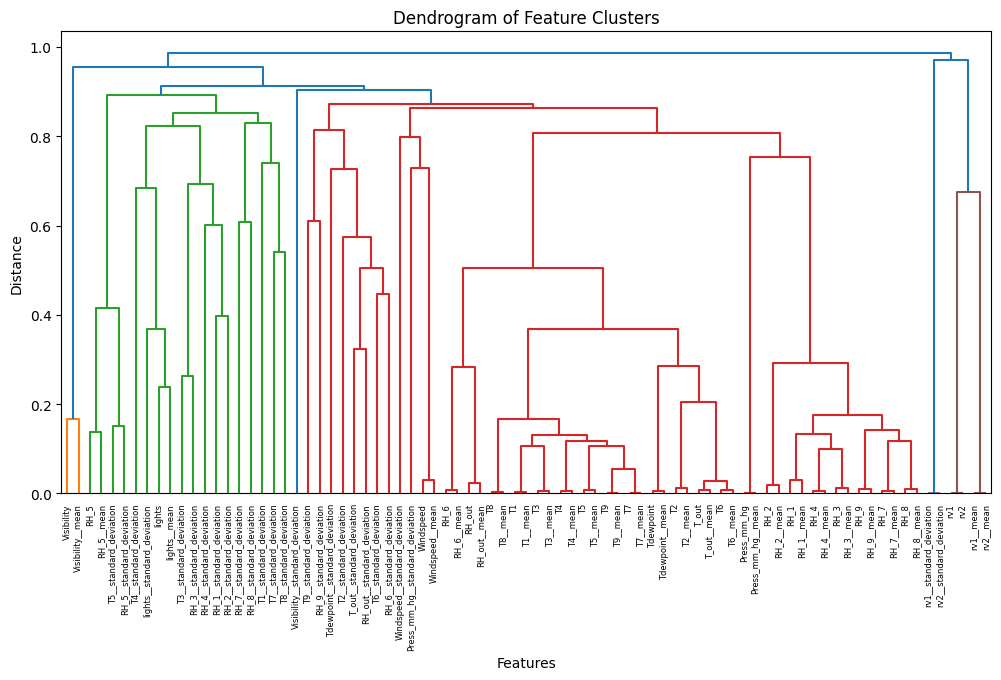

In [67]:
condensed_distance = squareform(distance_matrix)

# Perform hierarchical clustering using linkage
linked = linkage(condensed_distance, method='average')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=X_var_df.columns, color_threshold=0.9)
plt.title('Dendrogram of Feature Clusters')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.show()

In [68]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustered_df)

# Step 8: Apply Lasso without CV for Feature Selection
alpha = 0.05  # Set the regularization strength manually (tune as necessary)
lasso = Lasso(alpha=alpha, random_state=0)
lasso.fit(X_scaled, y)
lasso_selected_features = X_clustered_df.columns[(lasso.coef_ != 0)]
X_lasso_df = X_clustered_df# [lasso_selected_features]

In [69]:
X_lasso_df.shape

(19735, 73)

In [70]:
model = XGBRegressor(n_estimators=200, random_state=0, eval_metric='rmse')
model.fit(X_lasso_df, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [71]:
# perm_importance = permutation_importance(model, X_lasso_df, y, n_repeats=5, random_state=0)
# important_features = X_lasso_df.columns[perm_importance.importances_mean > 0.001]
perm_importance = permutation_importance(model, X_clustered_df, y, n_repeats=5, random_state=0)
important_features = X_clustered_df.columns[perm_importance.importances_mean > 0.001]
X_final_df = X_lasso_df[important_features]

In [72]:
X_final_df.shape

(19735, 73)

In [73]:
# Train-Test Split and Model Evaluation
X_train, X_test, y_train, y_test = train_test_split(X_final_df, y, test_size=0.2, random_state=42)
model = XGBRegressor(random_state=42, eval_metric='rmse')
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [74]:
y_pred_test.shape

(3947,)

In [75]:
print("Training Set Metrics:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_train, y_pred_train))
print("Mean Absolute Percentage Error (MSE):", mean_absolute_percentage_error(y_train, y_pred_train)*100)

print("\nTest Set Metrics:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_test))
print("Mean Absolute Percentage (MSE):", mean_absolute_percentage_error(y_test, y_pred_test)*100)

Training Set Metrics:
Mean Absolute Error (MAE): 20.376213318642588
Mean Absolute Percentage Error (MSE): 25.36198426236223

Test Set Metrics:
Mean Absolute Error (MAE): 35.735888218604856
Mean Absolute Percentage (MSE): 38.82168378312248


In [76]:
# Assuming `df` is already loaded with the original data

# Step 1: Define Features and Target
X = df.drop(columns=['Appliances', 'id', 'time'])  # Exclude the target column
y = df['Appliances']  # Define target variable

In [77]:
X.shape

(19735, 27)

In [78]:
# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train XGBoost Model
model = XGBRegressor(n_estimators=250, random_state=0, use_label_encoder=False, eval_metric='rmse')
model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Step 5: Evaluate Model
print("Training Set Metrics:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_train, y_pred_train))
print("Mean Absolute Percentage Error (MSE):", mean_absolute_percentage_error(y_train, y_pred_train)*100)

print("\nTest Set Metrics:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_test))
print("Mean Absolute Percentage (MSE):", mean_absolute_percentage_error(y_test, y_pred_test)*100)

Training Set Metrics:
Mean Absolute Error (MAE): 13.567925429748891
Mean Absolute Percentage Error (MSE): 18.054247543108826

Test Set Metrics:
Mean Absolute Error (MAE): 35.01552747139787
Mean Absolute Percentage (MSE): 37.40106293989613


In [79]:
# Assuming `df` is already loaded with the original data

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 3: Train XGBoost Model
model = XGBRegressor(n_estimators=250, random_state=0, use_label_encoder=False, eval_metric='rmse')
model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Step 5: Evaluate Model
print("Training Set Metrics:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_train, y_pred_train))
print("Mean Absolute Percentage Error (MSE):", mean_absolute_percentage_error(y_train, y_pred_train)*100)

print("\nTest Set Metrics:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_test))
print("Mean Absolute Percentage (MSE):", mean_absolute_percentage_error(y_test, y_pred_test)*100)

Training Set Metrics:
Mean Absolute Error (MAE): 10.827819598032185
Mean Absolute Percentage Error (MSE): 15.253707894129423

Test Set Metrics:
Mean Absolute Error (MAE): 33.57445705352266
Mean Absolute Percentage (MSE): 36.42914331737073


In [80]:
# Get columns in each DataFrame
columns_df1 = set(X_combined.columns)
columns_df2 = set(X_final_df.columns)

# 1. Columns only in df1
only_in_df1 = columns_df1 - columns_df2
print("Columns only in df1:", only_in_df1)

# 2. Columns only in df2
only_in_df2 = columns_df2 - columns_df1
print("Columns only in df2:", only_in_df2)

# 3. Columns in both df1 and df2
common_columns = columns_df1 & columns_df2
print("Columns in both df1 and df2:", common_columns)

Columns only in df1: {'RH_3__mean', 'rv2__standard_deviation', 'rv2', 'T9__mean', 'Press_mm_hg', 'RH_4__mean', 'rv2__mean', 'Tdewpoint__mean'}
Columns only in df2: set()
Columns in both df1 and df2: {'RH_8__mean', 'T3__mean', 'T_out', 'RH_7__standard_deviation', 'Visibility', 'T1', 'RH_7', 'RH_5__standard_deviation', 'T4', 'T4__mean', 'RH_2', 'Visibility__mean', 'lights__standard_deviation', 'T2__mean', 'rv1__standard_deviation', 'Press_mm_hg__standard_deviation', 'Tdewpoint', 'T7__mean', 'T6__standard_deviation', 'T7', 'RH_6', 'T4__standard_deviation', 'T3__standard_deviation', 'RH_9', 'lights__mean', 'RH_3', 'RH_out', 'Windspeed', 'T3', 'rv1', 'T9__standard_deviation', 'T8__standard_deviation', 'T6', 'Press_mm_hg__mean', 'T1__mean', 'RH_6__mean', 'rv1__mean', 'RH_4', 'T6__mean', 'Windspeed__mean', 'RH_1__mean', 'RH_1__standard_deviation', 'RH_2__standard_deviation', 'T7__standard_deviation', 'lights', 'RH_7__mean', 'RH_8__standard_deviation', 'RH_9__standard_deviation', 'RH_5', 'T5',

<Axes: >

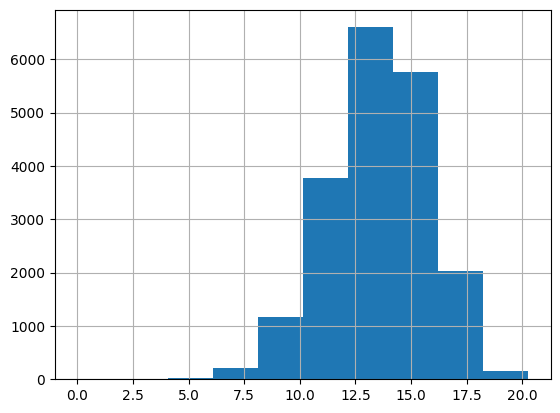

In [82]:
X_combined['rv2__standard_deviation'].hist()